### Loading datasets

In [1]:
import torch
import torchvision.transforms.functional as F
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from data.dataset import MultiDataset

from optical_flow.spynet import spynet_optical_flow 
from optical_flow.farneback import farneback_optical_flow

# Dataset and Loader
dataset_test = MultiDataset(
    ['data/same_vis_same_phys/train/sample_0/',
     'data/same_vis_same_phys/train/sample_1/',
     'data/same_vis_same_phys/train/sample_2/',
     'data/same_vis_same_phys/train/sample_3/'],
    img_size=(256, 256),
    buffer_size=3,
    random_order=True
    )

loader_train = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=4,  # we have modified data_parallel
    shuffle=False,  # we do not use this param
    drop_last=True,
    pin_memory=True)

# create loader iterator
iterator_train = iter(loader_train)

In [2]:
output = iterator_train.next()

## Testing optical flow

### Plotting

In [3]:
plt.rcParams["savefig.bbox"] = 'tight'


def show_imgs(imgs):
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
    plt.show()

    
def show_farneback_optical_flows(opt_flows):
    fig, axs = plt.subplots(ncols=len(opt_flows), squeeze=False)
    for i, opt_flow in enumerate(opt_flows):
        opt_flow = opt_flow.detach().numpy()
        hsv = np.zeros((256,256, 3), dtype=np.float32)
        hsv[..., 1] = 255
        mag, ang = cv2.cartToPolar(opt_flow[0, ...], opt_flow[1, ...])
        hsv[..., 0] = ang*180/np.pi/2
        hsv[..., 2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)
        bgr = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
        
        axs[0, i].imshow(np.asarray(bgr))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])    
    plt.show()


def save_spynet_optical_flows(opt_flows):
    fig, axs = plt.subplots(ncols=len(opt_flows), squeeze=False)
    for i, opt_flow in enumerate(opt_flows):
        objOutput = open(f'out_{i}.flo', 'wb')
        np.array([ 80, 73, 69, 72 ], np.uint8).tofile(objOutput)
        np.array([ opt_flow.shape[2], opt_flow.shape[1] ], np.int32).tofile(objOutput)
        np.array(opt_flow.transpose(1, 2, 0), np.float32).tofile(objOutput)
        objOutput.close()

### Masking 

### Metres to pixel based masking

In [4]:
# px_per_m calculation
q = 55.0 * np.pi / 180
focal_length = 256.0 / np.tan(q/2)
px_per_m = focal_length * 1/2
m_per_px = 1 / px_per_m

In [5]:
# backtracking 256 px_per_m to q
focal_length = 2 * 256
q = np.arctan(256.0 / focal_length) * 2 * 180 / np.pi

In [6]:
def scale2scale(value, oMin=-1.0, oMax=1.0, nMin=-1.0, nMax=1.0):
    """
    Convert linear scale (min/max) to another linear scale (min/max)
    value: value to be converted
    oMin: old minimum value
    oMax: old maximum value
    nMin: new minimum value
    nMax: new maximum value
    return: value mapped from old range to new range
    """
    oSpan = oMax - oMin
    nSpan = nMax - nMin
    result = ( ( value - oMin) / oSpan) * nSpan + nMin
    return result  


def bool_circle_mask(arr, xidx, yidx, rad):
    c, h, w = arr.shape
    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - xidx)**2 + (Y-yidx)**2)
    mask = dist_from_center <= rad
    mask = np.repeat(mask[np.newaxis, :, :], c, axis=0)
    return mask


def arr_circle_mask(arr, xidx, yidx, rad, default_val=0):
    result = np.ones_like(arr) * default_val
    mask = bool_circle_mask(arr, xidx, yidx, rad)
    result[mask] = arr[mask]
    return result


def tensor_arr_dist_circle_mask(arr, cx, cy, cr, extra_pad=0.05):
    arr = arr.detach().numpy()
    xidx = int(scale2scale(cx, -1.0, 1.0, 0.0, 256.0))
    yidx= int(scale2scale(cy, -1.0, 1.0, 256.0, 0.0))
    rad = int(scale2scale(cr + extra_pad, 0.0, 1.0, 0.0, 256.0 // 2))
    result = arr_circle_mask(arr, xidx, yidx, rad)
    result = torch.from_numpy(result.copy())
    return result


def tensor_img_px_circle_mask(img, px, py, pr):
    result = arr_circle_mask(img.detach().numpy(), px, py, pr)
    result = torch.from_numpy(result.copy())
    return result


def tensor_img_dist_circle_mask(img, cx, cy, cr, extra_pad=0.05):
    px = int(scale2scale(cx, -1.0, 1.0, 0.0, 256.0))
    py = int(scale2scale(cy, -1.0, 1.0, 256.0, 0.0))
    pr = int(scale2scale(cr + extra_pad, 0.0, 1.0, 0.0, 256.0 // 2))
    return tensor_img_px_circle_mask(img, px, py, pr) 

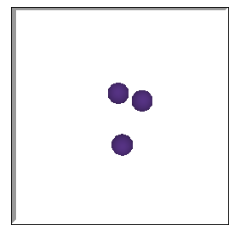

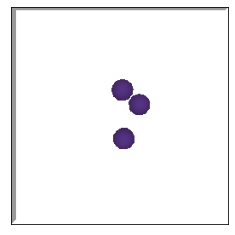

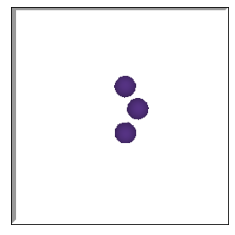

In [7]:
for i in range(len(output['img_data'][0])):
    show_imgs([output['img_data'][0, i]])

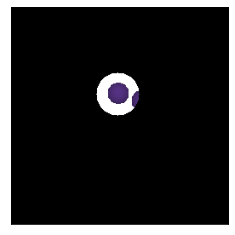

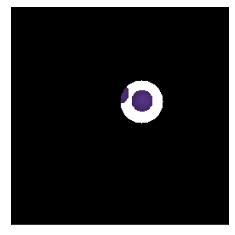

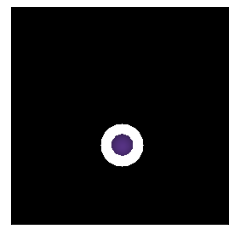

In [8]:
for cx,cy,cr in output['state_label'][0][0][:, [0,1,-1]].detach().numpy():
    show_imgs([tensor_img_dist_circle_mask(output['img_data'][0][0], cx, cy, cr + 0.05)])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


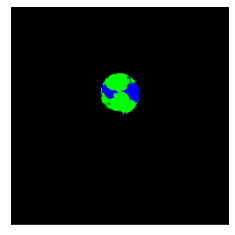

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


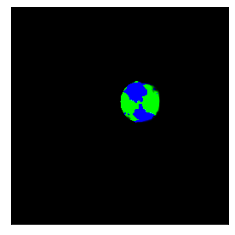

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


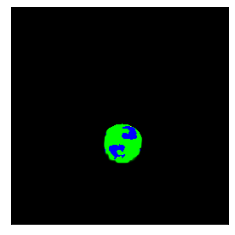

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


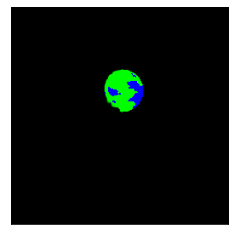

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


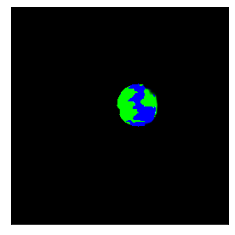

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


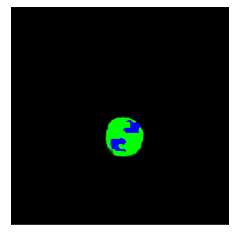

In [9]:
opt_flow_masks = []
cxs = []
cys = []
crs = []

for i in range(2):
    opt_flow = farneback_optical_flow(output['img_data'][0][i], output['img_data'][0][i+1])
    
    for j in range(3):
        cx = output['state_label'][0][i][j, 0]
        cy = output['state_label'][0][i][j, 1]
        cr = output['state_label'][0][i][j, -1]
        
        cxs.append(cx)
        cys.append(cy)
        crs.append(cr)    
        opt_flow_masks.append(tensor_arr_dist_circle_mask(opt_flow, cx, cy, cr, 0.1))

for i in range(len(opt_flow_masks)):
    show_farneback_optical_flows([opt_flow_masks[i]])